# Navigation

---

Below is the setup and training code for the first Udacity Deep Reinforcement Learning Project.

### 1. Start the Environment

Run the next code cell to install a few packages.  This is taken from the given code repository.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


Below loads in the environments. For the results shown here we load directly from the online Udacity workspace. If using a local implmentation change this to point to where the downloaded environment is located.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Loading the brain for the agent which is responsible for deciding the actions of the associated agent.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Running the code below allows us to investigate the state space and actions. This is taken from the default Udacity workbook.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Defining Our Agent

Here we define our agent using a very similiar structure to that from the Udacity example. Our agent uses a Deep Q-Network as the decision making algorithm. Below the defention is a more detailed discussion of the network architecture and hyperparameters used.

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import random

from dqn_agent import Agent

# resetting environment to get parameters
env_info = env.reset(train_mode=False)[brain_name]

# Network Structure
input_size = len(env_info.vector_observations[0])
hidden_sizes = [256, 64]
output_size = brain.vector_action_space_size

# Making the agent and setting the seed to be random
agent = Agent(input_size, output_size, seed=random.randint(1,100), fc_layers=hidden_sizes)

# Printing out the layers of the agents network
print(agent.qnetwork_local.layers)

ModuleList(
  (0): Linear(in_features=37, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=4, bias=True)
)


#### Network Architecture

For this project it was found the a three layer architecture provided good results. Here the first layer has 256 nodes, the second layer has 64 nodes, and the final layer has 4 nodes corresponding to the number of actions.

All layers except for the final layer use the ReLU activation function.

#### Training Algorithm

Here we use a Deep Q Network as the learning algorithm. This attempts to learn the Q value for every state and action pair which is then used when making decisions. 

Experience replay and a target-Q network are used to improve and stabilize training. Additionally, during training epsilon greedy action selection is used.

#### Hyperparameters

Replay Buffer Size                - 10,000  
Batch Size                        - 64  
Gamma (Future Discount)           - 0.99  
Tau (Target Network Update Rate)  - 0.001  
Learning Rate                     - 0.0005  
Update Rate (Steps before update) - 4  
Starting Epsilon Value            - 1.0  
Epsilon Decay Rate                - 0.997  
Maximum Episodes                  - 3,000  

### 4. Training the Agent

Below is the code for training the agent. The average score is printed every 100 episodes.

In [6]:
from collections import deque

scores = []
running_avg = []
scores_window = deque(maxlen=100)
eps = 1.0
eps_end = 0.01
eps_decay = 0.997
n_episodes = 3000
print_every = 100

for i_episodes in range(1, n_episodes+1):
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    
    while True:
        action = agent.act(state, eps=eps)
        env_info = env.step(int(action))[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    
    scores.append(score)
    scores_window.append(score)
    running_avg.append(np.mean(scores_window))
    eps = max(eps_end, eps_decay * eps)
    
    if i_episodes % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episodes, np.mean(scores_window)))
        
    if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episodes-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            

print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episodes, np.mean(scores_window)))

Episode 100	Average Score: 0.75
Episode 200	Average Score: 2.60
Episode 300	Average Score: 4.49
Episode 400	Average Score: 7.00
Episode 500	Average Score: 9.12
Episode 600	Average Score: 10.13
Episode 700	Average Score: 11.02
Episode 800	Average Score: 11.14
Episode 900	Average Score: 12.44

Environment solved in 880 episodes!	Average Score: 13.00
Episode 980	Average Score: 13.00


### 5. Plotting the Resuts

Below is code for plotting both the score from each individual episode as well as the score averaged over the previous 100 episodes.

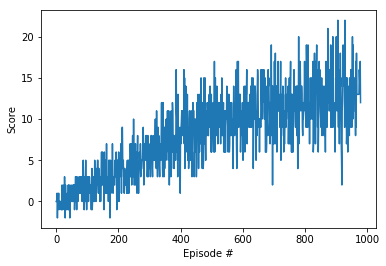

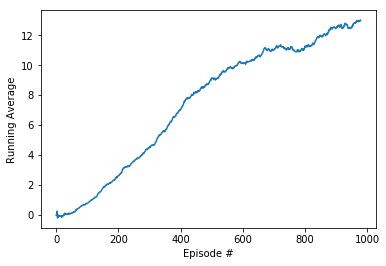

In [7]:
# Ploting Results

%matplotlib inline
import matplotlib.pyplot as plt


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(running_avg)), running_avg)
plt.ylabel('Running Average')
plt.xlabel('Episode #')
plt.show()

### 6. Future Work

One interesting direction for future work would be to implement a prioritized replay buffer. This would potentially improve training speed as it would help to ensure that the expereinces seen during replay would be more impactful.

A second direction for future work would be to do a more extensive hyperparameter sweep. The hyperparameteres here were selected hueristically and do not necessarily reflect the optimal values. Additional testing would also be helpful here to ensure that these hyperparameters are good rather than just demonstrating them once.